In [1]:
import numpy as np
import pandas as pd
import lmfit as lm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib notebook

import plotly
import plotly.graph_objects as go

In [2]:
datadir = '/home/ckampa/data/hallprobecalib_extras/datafiles/metrology/'
file = datadir + 'Card_Points_Sample_19.csv'

In [177]:
plotdir = '/home/ckampa/data/plots/metrology/'

# Load Data

In [8]:
def load_data(filename=file):
    # load file into lines
    with open(filename, 'r') as f:
        lines = [f_.rstrip('\n') for f_ in f.readlines()]

    # parse file line by line 
    xs = []; ys = []; zs = []; sections = []
    sample = int(lines[0].split(',')[0][lines[0].find('#')+1:])
    for line in lines[1:]:
        if line.lstrip(' ')[:7] == 'Section':
            section = int(line.split(',')[0][line.find('#')+1:])
        elif (line[:3] != '"""') and (line[0] != ','):
            x, y, z = [float(l) for l in line.split(',')]
            xs.append(x)
            ys.append(y)
            zs.append(z)
            sections.append(section)
    df = pd.DataFrame({'x':xs, 'y':ys, 'z':zs, 'section':sections})
    
    return df

In [9]:
df = load_data()

In [10]:
df

,x,y,z,section
0,2.45016,0.69055,0.07801,1
1,2.50142,0.69390,0.07746,1
2,2.55167,0.69347,0.07701,1
3,2.60218,0.69367,0.07649,1
4,2.65178,0.69368,0.07604,1
...,...,...,...,...
83,1.94949,0.84141,0.07933,6
84,1.93465,0.84173,0.07940,6
85,1.91980,0.84165,0.07951,6
86,1.90468,0.84164,0.07970,6


# Simple Plots

## Matplotlib

In [36]:
def simple_plot(df, sample, equal_axes=False):
    # data for plane
    xmin = -2.5; xmax= 3.5
    ymin = -2; ymax= 2.1
    xs = np.linspace(xmin, xmax, 10)
    ys = np.linspace(ymin, ymax, 10)
    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros_like(xx)
    # plot!
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx,yy,zz, alpha=0.2)
    # loop through sections
    for sec in df.section.unique():
        df_ = df.query(f'section == {sec}')
        ax.scatter(df_.x, df_.y, df_.z, s=3, label=f'{sec}')
    # origin
    ax.scatter([0],[0],[0], marker='x', s=20, color='black', label='Origin')
    # labels etc
    ax.set_xlabel('x [inch]')
    ax.set_ylabel('y [inch]')
    ax.set_zlabel('z [inch]')
    ax.set_title(f'Hall Probe Card CMM: Sample #{sample}')
    ax.legend(title='Section')
    
    if equal_axes:
        max_range = ((df.max()-df.min()))[['x','y','z']].values.max()/2
        mid_x = (df.x.max() + min(df.x.min(),xmin))/2
        mid_y = (df.y.max() + df.y.min())/2
        mid_z = (df.z.max() + 0)/2
        ax.set_xlim(mid_x-max_range, mid_x+max_range)
        ax.set_ylim(mid_y-max_range, mid_y+max_range)
        ax.set_zlim(mid_z-max_range, mid_z+max_range)
    
    return fig, ax

<IPython.core.display.Javascript object>


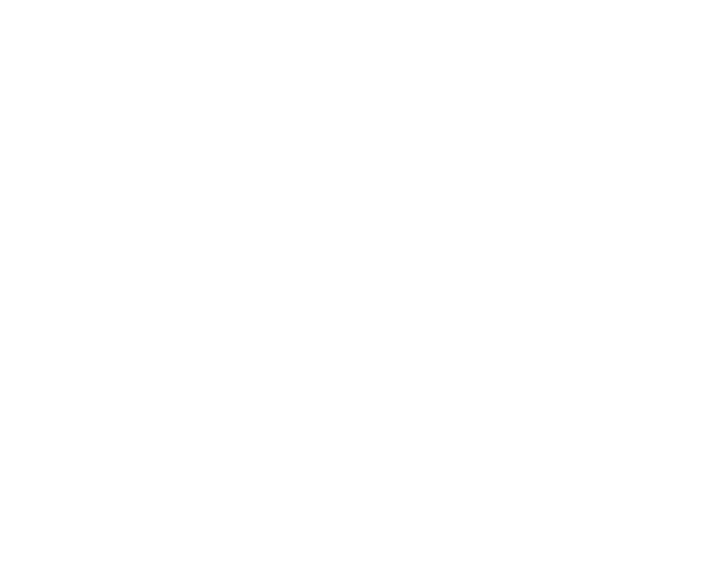

<IPython.core.display.Javascript object>


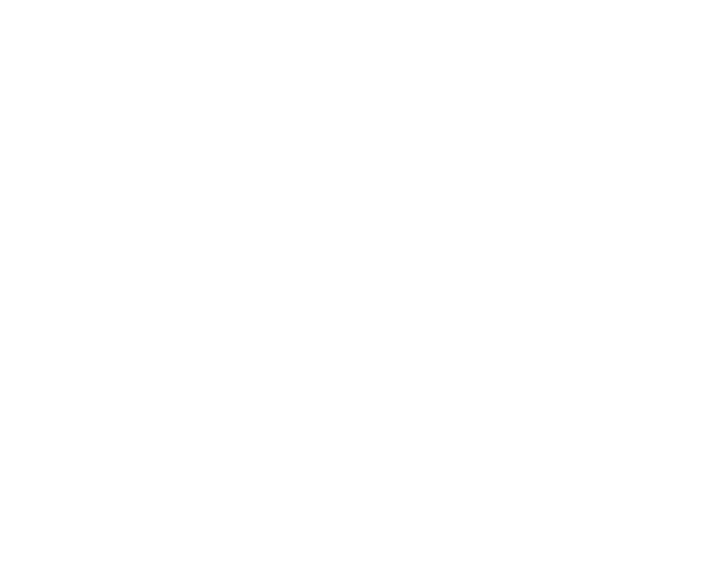

In [37]:
fig, ax = simple_plot(df, sample, equal_axes=True);

<IPython.core.display.Javascript object>


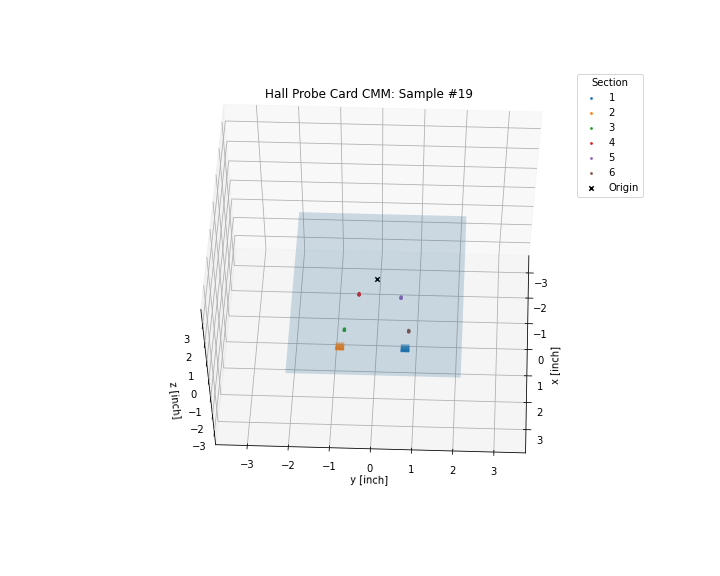

In [38]:
fig

## Plotly

In [174]:
def simple_plot_plotly(df, sample, equal_axes=False):
    # data for plane
    xmin = -1.5; xmax= 3.5
    ymin = -2; ymax= 2.1
    xs = np.linspace(xmin, xmax, 2)
    ys = np.linspace(ymin, ymax, 2)
    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros_like(xx)
    # plot!
    scatter_data = []
    for sec in df.section.unique():
        df_ = df.query(f'section == {sec}')
        scatter_data.append(go.Scatter3d(x=df_.x, y=df_.y, z=df_.z, mode='markers',
                                         marker=dict(size=1), name=f'Section {sec}'))
    scatter_data.append(go.Scatter3d(x=[0], y=[0], z=[0], 
                                     marker=dict(size=4, symbol='cross', color='black'), name='Origin'))
    n = 200
    fig = go.Figure(data=[go.Surface(x=xx, y=yy, z=zz, opacity=0,
                                     colorscale=[f'rgb({n},{n},{n})',f'rgb({n},{n},{n})'])])#+scatter_data)
    fig.update_traces(showscale=False)
    fig.add_traces(data=scatter_data)
    
    fig.update_layout(title=f'Hall Probe Card CMM: Sample #{sample}',
                      scene=dict(
                          xaxis_title='x [inch]',
                          yaxis_title='y [inch]',
                          zaxis_title='z [inch]',
                      ))
    
    
    camera = dict(
        up=dict(x=-1, y=0, z=0),
        center=dict(x=(xmin+xmax)/2-0.5, y=(ymin+ymax)/2, z=0),
        eye=dict(x=(xmin+xmax)/2-.25, y=(ymin+ymax)/2, z=3),
    )
        
    if equal_axes:
        fig.update_layout(scene=dict(aspectmode='data'))
        camera = dict(
            up=dict(x=-1, y=0, z=0),
            center=dict(x=(xmin+xmax)/2-0.5, y=(ymin+ymax)/2, z=0),
            eye=dict(x=(xmin+xmax)/2, y=(ymin+ymax)/2, z=6),
        )
    
    fig.update_layout(scene_camera=camera)
    
    return fig

In [175]:
fig1 = simple_plot_plotly(df, sample, equal_axes=False)
fig2 = simple_plot_plotly(df, sample, equal_axes=True)

In [178]:
fig1.write_html(plotdir+'CMM_example_plot_unequal_axes.html')
fig2.write_html(plotdir+'CMM_example_plot_equal_axes.html')

In [160]:
plotly.offline.plot(fig)

'temp-plot.html'

# Fitting a Plane

In [308]:
df[['x','y','z']].values.T.shape

(3, 88)

In [316]:
def plane_fit_SVD(df):
    # collect positional points from dataframe
    points = df[['x','y','z']].values.T
    # subtract centroid
    centroid = (np.sum(points,axis=1) / len(df))
    points_c = points - centroid[:,None]
    # calculate svd
    u, _, _ = np.linalg.svd(points_c)
    # normal vector is left singular vector with least singular value
    norm_v = u[:,2]
    return norm_v, centroid

In [356]:
def plot_plane_fit(df, norm_v, centroid, equal_axes=False, title='Simultaneous Fit', ax=None):
    # data for plane
    xmin = df.x.min(); xmax = df.x.max()
    ymin = df.y.min(); ymax= df.y.max()
    xs = np.linspace(xmin, xmax, 2)
    ys = np.linspace(ymin, ymax, 2)
    xx, yy = np.meshgrid(xs, ys)
    d = - norm_v @ centroid
    zz = (norm_v[0]*xx + norm_v[1]*yy + d) / (-norm_v[2])
    # plot!
    if ax == None:
        fig = plt.figure(figsize=(15,12))
        ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx,yy,zz, alpha=0.2,
                           label=f'Plane from SVD:\n'+
                           f'Centroid = ({centroid[0]:.3E},{centroid[1]:.3E},{centroid[2]:.3E})\n'+
                           f'Normal Vec. = ({norm_v[0]:.3E}, {norm_v[1]:.3E}, {norm_v[2]:.3E})')
    surf._facecolors2d=surf._facecolors3d
    surf._edgecolors2d=surf._edgecolors3d
    ##ax.plot(*[centroid[i]+[0, norm_v[i]] for i in [0,1,2]], label='Fit Plane Norm (at data centroid)')
    # loop through sections
    for sec in df.section.unique():
        df_ = df.query(f'section == {sec}')
        ax.scatter(df_.x, df_.y, df_.z, s=3, label=f'Section {sec}')
    # origin
    #ax.scatter([0],[0],[0], marker='x', s=20, color='black', label='Origin')
    # labels etc
    ax.set_xlabel('x [inch]')
    ax.set_ylabel('y [inch]')
    ax.set_zlabel('z [inch]')
    ax.set_title(f'Hall Probe Card CMM: Sample #{sample}\n{title}')
    #ax.legend(title='Section')
    ax.legend()
    
    if equal_axes:
        max_range = ((df.max()-df.min()))[['x','y','z']].values.max()/2
        mid_x = (df.x.max() + df.x.min())/2
        mid_y = (df.y.max() + df.y.min())/2
        mid_z = (df.z.max() + df.z.min())/2
        ax.set_xlim(mid_x-max_range, mid_x+max_range)
        ax.set_ylim(mid_y-max_range, mid_y+max_range)
        ax.set_zlim(mid_z-max_range, mid_z+max_range)
    
    return ax

## All Sections Simultaneously

In [317]:
norm_v, centroid = plane_fit_SVD(df)

In [318]:
norm_v

array([7.49037305e-04, 2.22117139e-03, 9.99997253e-01])

In [319]:
centroid

array([1.86691909, 0.04953625, 0.08034818])

In [320]:
df.mean()

x          1.866919
y          0.049536
z          0.080348
section    3.136364
dtype: float64

In [310]:
df.x.sum() / len(df)

1.866919090909091

<IPython.core.display.Javascript object>


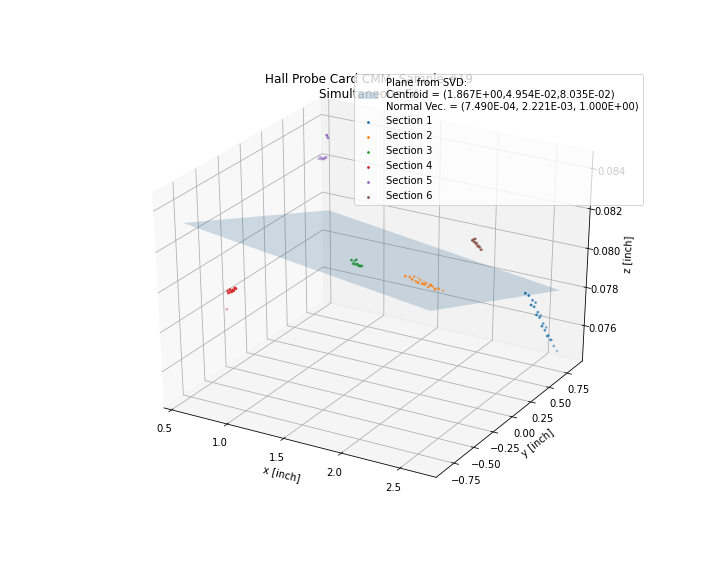

In [339]:
ax = plot_plane_fit(df, norm_v, centroid, equal_axes=False, title='Simultaneous Fit')

## Individual Sections

### Normal Vector Straight Average, Centroid Straight Average

In [352]:
sections = list(df.section.unique())
centroids = []
norm_vs = []
for sec in df.section.unique():
    df_ = df.query(f'section == {sec}')
    norm_v_, centroid_ = plane_fit_SVD(df_)
    norm_vs.append(norm_v_)
    centroids.append(centroid_)
#norm_vs = np.array(norm_vs)
#centroids = np.array(centroids)
planes_dict = {'section':sections, 'norm_v': norm_vs, 'centroid': centroids}

In [353]:
planes_dict

{'section': [1, 2, 3, 4, 5, 6],
 'norm_v': [array([-0.01047414, -0.00742444, -0.99991758]),
  array([-0.00144583, -0.00357987, -0.99999255]),
  array([-0.00168998, -0.00212287, -0.99999632]),
  array([ 0.00761703,  0.00953053, -0.99992557]),
  array([ 0.01136462,  0.00112237, -0.99993479]),
  array([-5.71474449e-03, -6.89546816e-04, -9.99983433e-01])],
 'centroid': [array([2.5499085, 0.768659 , 0.076474 ]),
  array([ 2.5479455, -0.7676635,  0.082706 ]),
  array([ 1.93719917, -0.68728917,  0.0826175 ]),
  array([ 0.62004   , -0.3958025 ,  0.07869083]),
  array([0.7088175 , 0.61048917, 0.08314333]),
  array([1.92826   , 0.83420917, 0.07946833])]}

<IPython.core.display.Javascript object>


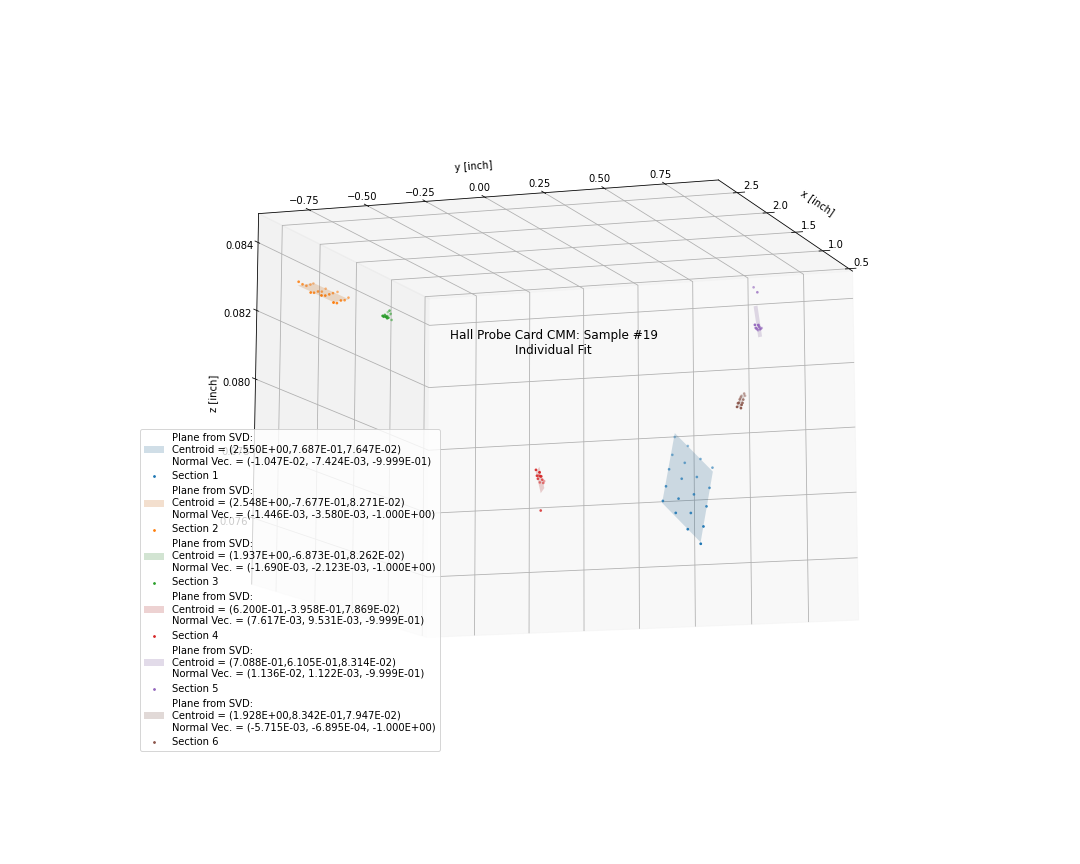

In [357]:
ax = None
for i, sec in enumerate(sections):
    df_ = df.query(f'section == {sec}')
    norm_ = planes_dict['norm_v'][i]
    cent_ = planes_dict['centroid'][i]
    ax = plot_plane_fit(df_, norm_, cent_, equal_axes=False, title='Individual Fit', ax=ax)

In [345]:
norm_vs.shape

(6, 3)

In [ ]:
planes_dict = {'section':sections, 'norm_v': norm_vs, 'centroid': centroids}

In [364]:
cs = np.array(planes_dict['centroid'])
ns = np.array(planes_dict['norm_v'])

In [361]:
cs.shape

(6, 3)

In [362]:
np.mean(cs,axis=0)

array([1.71536178, 0.06043369, 0.08051667])

In [363]:
centroid

array([1.86691909, 0.04953625, 0.08034818])

In [365]:
np.mean(ns, axis=0)

array([-5.71748347e-05, -5.27305389e-04, -9.99958374e-01])

In [366]:
norm_v

array([7.49037305e-04, 2.22117139e-03, 9.99997253e-01])

In [367]:
40+4*12

88

In [370]:
nv = np.mean(ns, axis=0)
cd = np.mean(cs,axis=0)

In [369]:
nv

array([-5.71748347e-05, -5.27305389e-04, -9.99958374e-01])

In [376]:
# individual

In [373]:
x = 0; y= 0
d = - nv @ cd
z = (nv[0]*x + nv[1]*y + d) / (-nv[2])

In [375]:
z

0.08064661461482299

In [377]:
# simultaneous

In [378]:
x = 0; y = 0
d = -norm_v @ centroid
z = (norm_v[0]*x + norm_v[1]*y + d) / (-norm_v[2])

In [379]:
z

0.08185660650798458

# Scratch

## Plane Fit With Generated Data

In [296]:
# generate random test points
n = 20
delta = 0.01 # random displacement scale
origin = np.random.rand(3,1) # plane origin
basis = np.random.rand(3,2) # plane basis vectors
norm_v = np.cross(basis[:,0], basis[:,1]) # normal to plane
norm_v = norm_v / np.linalg.norm(norm_v)
coefficients = np.random.rand(2, n) # random coefficients

# generate points on the plane with noise
points = np.dot(basis, coefficients)\
        + np.dot(origin, np.full((1,n),1))\
        + delta * np.random.rand(3,n) # displacement

# find best-fitting plane
# subtract centroid
points_c = points - (np.sum(points,axis=1) / n)[:,None]

# svd
u, s, vh = np.linalg.svd(points_c)
#norm_v_fit = u[:,0]
#norm_v_fit = u.T
norm_v_fit = u[:,2]

In [297]:
norm_v_fit.T

array([-0.40114008,  0.45058886,  0.79753139])

In [298]:
norm_v_fit, norm_v

(array([-0.40114008,  0.45058886,  0.79753139]),
 array([ 0.40289959, -0.45062559, -0.79662318]))

In [289]:
np.linalg.norm(norm_v), np.linalg.norm(norm_v_fit)

(0.4031038688766465, 1.0)

In [287]:
np.cross(norm_v_fit, norm_v)

array([1.38777878e-16, 4.85722573e-17, 4.16333634e-17])

In [278]:
norm_v_fit.shape

(3,)

In [279]:
np.dot(norm_v_fit, basis)

array([ 0.0000000e+00, -1.2490009e-16])

In [280]:
basis

array([[0.12857629, 0.14063377],
       [0.71320984, 0.01554513],
       [0.84134486, 0.16614853]])

In [182]:
points.shape

(3, 20)

In [188]:
origin.shape

(3, 1)

In [190]:
origin

array([[0.70421736],
       [0.56947827],
       [0.53793894]])

In [189]:
np.dot(origin, np.full((1,n),1))

array([[0.70421736, 0.70421736, 0.70421736, 0.70421736, 0.70421736,
        0.70421736, 0.70421736, 0.70421736, 0.70421736, 0.70421736,
        0.70421736, 0.70421736, 0.70421736, 0.70421736, 0.70421736,
        0.70421736, 0.70421736, 0.70421736, 0.70421736, 0.70421736],
       [0.56947827, 0.56947827, 0.56947827, 0.56947827, 0.56947827,
        0.56947827, 0.56947827, 0.56947827, 0.56947827, 0.56947827,
        0.56947827, 0.56947827, 0.56947827, 0.56947827, 0.56947827,
        0.56947827, 0.56947827, 0.56947827, 0.56947827, 0.56947827],
       [0.53793894, 0.53793894, 0.53793894, 0.53793894, 0.53793894,
        0.53793894, 0.53793894, 0.53793894, 0.53793894, 0.53793894,
        0.53793894, 0.53793894, 0.53793894, 0.53793894, 0.53793894,
        0.53793894, 0.53793894, 0.53793894, 0.53793894, 0.53793894]])

In [198]:
origin[1,0]

0.9216504657146393

In [206]:
np.cross(basis[:,0], basis[:,1])

array([ 0.40275187, -0.27056632, -0.26231452])

<IPython.core.display.Javascript object>


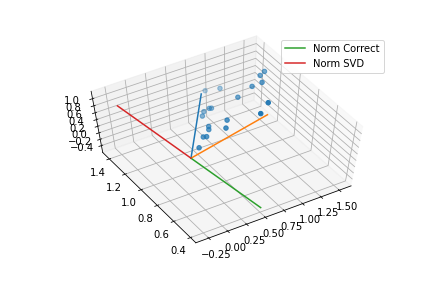

In [299]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*points)
ax.plot([origin[0,0],origin[0,0]+basis[0,0]],[origin[1,0],origin[1,0]+basis[1,0]],[origin[2,0],origin[2,0]+basis[2,0]])
ax.plot([origin[0,0],origin[0,0]+basis[0,1]],[origin[1,0],origin[1,0]+basis[1,1]],[origin[2,0],origin[2,0]+basis[2,1]])
ax.plot([origin[0,0],origin[0,0]+norm_v[0]],[origin[1,0],origin[1,0]+norm_v[1]],[origin[2,0],origin[2,0]+norm_v[2]], label='Norm Correct')
ax.plot([origin[0,0],origin[0,0]+norm_v_fit[0]],[origin[1,0],origin[1,0]+norm_v_fit[1]],[origin[2,0],origin[2,0]+norm_v_fit[2]], label='Norm SVD')
ax.legend()

- Only looks weird because axis scaling is incorrect

In [209]:
np.dot(norm_v,basis[:,0]), np.dot(norm_v,basis[:,1])

(0.0, 0.0)

In [193]:
np.sum(points,1) / n

array([0.41591072, 1.07973495, 1.10356281])

In [214]:
origin

array([[0.58796095],
       [0.61948639],
       [0.83331108]])

In [218]:
points.T

array([[1.25484467, 1.05658992, 1.41059563],
       [0.75896908, 0.75127551, 0.96890873],
       [1.09048004, 1.0389585 , 1.17137636],
       [1.54377929, 1.37941576, 1.51543636],
       [0.97356144, 0.97898078, 1.06761544],
       [1.55821121, 1.46302628, 1.46642548],
       [1.35379877, 1.08208151, 1.53990304],
       [1.35784423, 1.12634886, 1.5070355 ],
       [0.78760842, 0.84104785, 0.91811003],
       [1.05944323, 1.05200489, 1.11389699],
       [1.11394074, 1.02038661, 1.23213263],
       [0.88396064, 0.92925351, 0.97416493],
       [0.90382855, 0.90942953, 1.03247842],
       [1.06143896, 1.01769041, 1.15980413],
       [1.21646086, 1.05129314, 1.35185446],
       [1.24794286, 1.00197901, 1.45240652],
       [1.66961399, 1.42903199, 1.66024675],
       [1.48531763, 1.28409607, 1.52525344],
       [1.2447657 , 1.05293336, 1.39397991],
       [1.12750305, 1.11584438, 1.15503293]])

In [221]:
(np.sum(points,axis=1) / n)

array([1.18466567, 1.07908339, 1.28083288])

In [225]:
((points - (np.sum(points,axis=1) / n)[:,None]) == (points.T - np.sum(points,axis=1) / n).T).all()

True

In [227]:
(np.sum(points,axis=1) / n)[:,None]

array([[1.18466567],
       [1.07908339],
       [1.28083288]])

In [228]:
points

array([[1.25484467, 0.75896908, 1.09048004, 1.54377929, 0.97356144,
        1.55821121, 1.35379877, 1.35784423, 0.78760842, 1.05944323,
        1.11394074, 0.88396064, 0.90382855, 1.06143896, 1.21646086,
        1.24794286, 1.66961399, 1.48531763, 1.2447657 , 1.12750305],
       [1.05658992, 0.75127551, 1.0389585 , 1.37941576, 0.97898078,
        1.46302628, 1.08208151, 1.12634886, 0.84104785, 1.05200489,
        1.02038661, 0.92925351, 0.90942953, 1.01769041, 1.05129314,
        1.00197901, 1.42903199, 1.28409607, 1.05293336, 1.11584438],
       [1.41059563, 0.96890873, 1.17137636, 1.51543636, 1.06761544,
        1.46642548, 1.53990304, 1.5070355 , 0.91811003, 1.11389699,
        1.23213263, 0.97416493, 1.03247842, 1.15980413, 1.35185446,
        1.45240652, 1.66024675, 1.52525344, 1.39397991, 1.15503293]])

In [229]:
u, s, vh = np.linalg.svd(points)

In [233]:
svd = np.transpose(np.linalg.svd(points))

In [238]:
svd[2].shape

(20, 20)

In [246]:
svd[0][:,0]

array([-0.58087814, -0.52386461, -0.62301401])

In [241]:
svd[0], svd[0,:,0].T

(array([[-0.58087814,  0.01423063, -0.81386613],
        [-0.52386461,  0.75872975,  0.38716281],
        [-0.62301401, -0.65125008,  0.4332746 ]]),
 array([[-0.58087814, -0.52386461, -0.62301401],
        [ 0.01423063,  0.75872975, -0.65125008],
        [-0.81386613,  0.38716281,  0.4332746 ]]))

In [230]:
u

array([[-0.58087814,  0.01423063, -0.81386613],
       [-0.52386461,  0.75872975,  0.38716281],
       [-0.62301401, -0.65125008,  0.4332746 ]])

In [231]:
points.shape

(3, 20)

In [247]:
# find best-fitting plane
# subtract centroid
points = points - (np.sum(points,axis=1) / n)[:,None]

# svd
u, s, vh = np.linalg.svd(points)
normal_v_fit = u[:,0]

In [249]:
norm_v, normal_v_fit

(array([ 0.40275187, -0.27056632, -0.26231452]),
 array([-0.6813107 , -0.45147632, -0.57618128]))

In [253]:
u

array([[-0.6813107 ,  0.06511059, -0.72909282],
       [-0.45147632,  0.74664083,  0.48856587],
       [-0.57618128, -0.6620333 ,  0.47929849]])

In [251]:
np.dot(norm_v, basis[:,0]), np.dot(norm_v, basis[:,1])

(0.0, 0.0)

In [252]:
np.dot(normal_v_fit, basis[:,0]), np.dot(normal_v_fit, basis[:,1])

(-0.6603292177526047, -1.1868236008797028)

In [212]:
points.shape

(3, 20)

In [216]:
points

array([[1.25484467, 0.75896908, 1.09048004, 1.54377929, 0.97356144,
        1.55821121, 1.35379877, 1.35784423, 0.78760842, 1.05944323,
        1.11394074, 0.88396064, 0.90382855, 1.06143896, 1.21646086,
        1.24794286, 1.66961399, 1.48531763, 1.2447657 , 1.12750305],
       [1.05658992, 0.75127551, 1.0389585 , 1.37941576, 0.97898078,
        1.46302628, 1.08208151, 1.12634886, 0.84104785, 1.05200489,
        1.02038661, 0.92925351, 0.90942953, 1.01769041, 1.05129314,
        1.00197901, 1.42903199, 1.28409607, 1.05293336, 1.11584438],
       [1.41059563, 0.96890873, 1.17137636, 1.51543636, 1.06761544,
        1.46642548, 1.53990304, 1.5070355 , 0.91811003, 1.11389699,
        1.23213263, 0.97416493, 1.03247842, 1.15980413, 1.35185446,
        1.45240652, 1.66024675, 1.52525344, 1.39397991, 1.15503293]])